# 利用logistic regression 和 neural network实现手写数据集识别

## 1.数据准备阶段

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [7]:
def loadData(filePath,transpose=True):
    data = sio.loadmat(filePath)
    y = data['y']  #(5000,1)的array
    y = y.flatten()  #(5000,)的一维array
    X = data['X'] #(5000,400)的array，但其中的400转换成(20,20)任需要再转置才能正常绘图

    if transpose == True:
        X = np.array([img.reshape(20,20).T for img in X]) #(5000,20,20)
        X = np.array([img.flatten() for img in X])
    return X,y
filePath = './ex3data1.mat'
X,y = loadData(filePath)
print('X.shape:',X.shape)
print('y.shape:',y.shape)


X.shape: (5000, 400)
y.shape: (5000,)


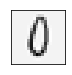

this is a 10 figure.


In [9]:
def plot_one_img(X):
    m = X.shape[0]
    number = np.random.randint(0,m)
    fig,ax = plt.subplots(figsize=(1,1))
    ax.matshow(X[number].reshape(20,20),cmap=matplotlib.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print('this is a',y[number],'figure.')
    return None
plot_one_img(X)
    

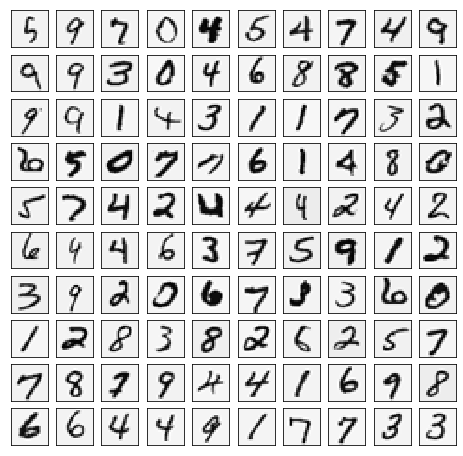

In [10]:
def plot_100_img(X):
    m = X.shape[0]
    numble_idx = np.random.choice(np.arange(m),100)
    sample_img = X[numble_idx,:]
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))
    for r in range(10):
        for c in range(10):
            ax_array[r,c].matshow(sample_img[r*10+c,:].reshape(20,20),cmap=matplotlib.cm.binary)
            plt.xticks([])
            plt.yticks([])
    plt.show()
    return None
plot_100_img(X)